## 初始化

引入Oneke相关的的库

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    KeepLargestConnectedComponentd
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import sys

### 数据集划分

默认进行随机划分，使用最后的8个作为测试集合。

`seg_idx = 1`可以通过修改seg_idx的值选择训练那个模型

  1. `1`代表训练inskull
  2. `2`代表训练outskull
  3. `3`代表训练{out-in}skull

In [2]:
import random
import os
from onekey_algo.custom.components.Radiology import diagnose_3d_image_mask_settings

root_dir = r'D:\20220421-FANBIN'
model_root = os.path.join(root_dir, 'models')
os.makedirs(model_root, exist_ok=True)
# os.makedirs(inference_dir, exist_ok=True)
roi_size = (48, 48, 48)

# 这里选择任务类型
seg_idx = 2
seg_type = ['_hippo-L', '_hippo-R', 'LEG'][seg_idx]

train_images = sorted(glob.glob(os.path.join(root_dir, 'images', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, 'masks_12', "*.nii.gz")))

assert len(train_images) == len(train_labels)        
# diagnose_3d_image_mask_settings(train_images, train_labels, verbose=True)
all_files = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels) #if '-' not in image_name[-10:]
]

# random.shuffle(all_files)
train_files = all_files[8:]
val_files = all_files[:8]
print(f"一共获取到{len(train_files)}训练样本")
print(f"一共获取到{len(val_files)}测试样本")

一共获取到124训练样本
一共获取到8测试样本


In [3]:
val_files

[{'image': 'D:\\20220421-FANBIN\\images\\00176749.nii.gz',
  'label': 'D:\\20220421-FANBIN\\masks_12\\00176749.nii.gz'},
 {'image': 'D:\\20220421-FANBIN\\images\\17026055.nii.gz',
  'label': 'D:\\20220421-FANBIN\\masks_12\\17026055.nii.gz'},
 {'image': 'D:\\20220421-FANBIN\\images\\1707170974.nii.gz',
  'label': 'D:\\20220421-FANBIN\\masks_12\\1707170974.nii.gz'},
 {'image': 'D:\\20220421-FANBIN\\images\\1707296697.nii.gz',
  'label': 'D:\\20220421-FANBIN\\masks_12\\1707296697.nii.gz'},
 {'image': 'D:\\20220421-FANBIN\\images\\1708204504.nii.gz',
  'label': 'D:\\20220421-FANBIN\\masks_12\\1708204504.nii.gz'},
 {'image': 'D:\\20220421-FANBIN\\images\\1709176921.nii.gz',
  'label': 'D:\\20220421-FANBIN\\masks_12\\1709176921.nii.gz'},
 {'image': 'D:\\20220421-FANBIN\\images\\17098412.nii.gz',
  'label': 'D:\\20220421-FANBIN\\masks_12\\17098412.nii.gz'},
 {'image': 'D:\\20220421-FANBIN\\images\\1710035907.nii.gz',
  'label': 'D:\\20220421-FANBIN\\masks_12\\1710035907.nii.gz'}]

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

image shape: (320, 320, 20)


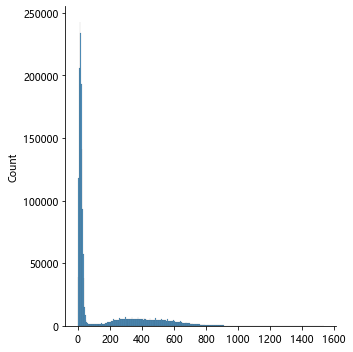

In [4]:
import nibabel as nib
import numpy as np
import seaborn as sns
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = np.array(nib.load(val_files[2]['image']).dataobj)
print(f"image shape: {val_data_example.shape}")
sns.displot(np.reshape(val_data_example, (-1)))

image shape: torch.Size([1, 161, 161, 85])


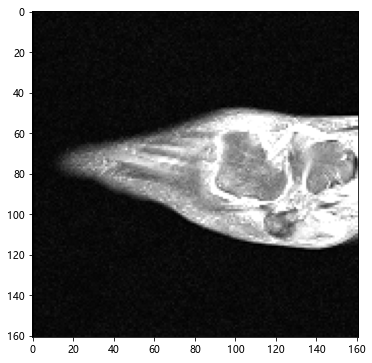

label shape: torch.Size([1, 161, 161, 85])


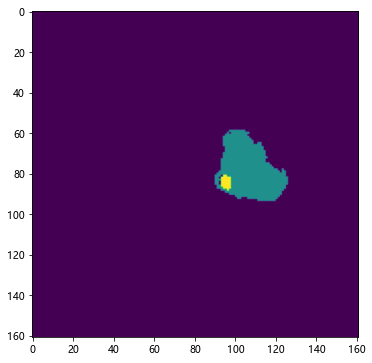

In [5]:
set_determinism(seed=0)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1., 1., 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=500,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=roi_size,
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1., 1., 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=500,
            b_min=0.0, b_max=1, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.1, num_workers=10)
train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=8)

# val_data_example = np.array(nib.load(val_files[2]['label']).dataobj)
# print(f"image shape: {val_data_example.shape}")
# plt.figure("image", (24, 6))
# plt.imshow(val_data_example[:, :, 3], cmap="gray")
# plt.show()

slice_idx = 8
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
plt.imshow(val_data_example["image"][0, :, :, slice_idx].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
plt.imshow(val_data_example["label"][0, :, :, slice_idx].detach().cpu())
plt.show()

### Dataloader

检查Transform以及相应的Dataloader。

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  And set `num_workers` to enable multi-threads during caching.  If want to to try the regular Dataset, just change to use the commented code below.

## 生成 Model, Loss, Optimizer

In [10]:
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceFocalLoss, DiceCELoss

num_classes = 3
device = torch.device(f"cuda")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric = DiceMetric(include_background=False, reduction="mean_channel")
if os.path.exists(os.path.join(model_root, f"{seg_type}_unet_best_metric_model.pth")):
    print('加载预训练模型...')
    model.load_state_dict(torch.load(os.path.join(model_root, f"{seg_type}_unet_best_metric_model.pth"), map_location=device)['state_dict'])

加载预训练模型...


### 模型训练

`max_epochs`最大迭代次数，int类型，默认： 600

`val_interval` 多少次训练进行一次validation，默认： 2

In [6]:
max_epochs = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=num_classes)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=num_classes)])
early_stopping_epoch = 64
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 4 == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        metric_values = []
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                metric_values.append(dice_metric(y_pred=val_outputs, y=val_labels))

            # aggregate the final mean dice result
            metric_value = torch.mean(torch.cat(metric_values, dim=0), dim=0)
            print(metric_value)
#             dice_metric.aggregate.item()
            dice_metric.reset()
            if metric_value[0] > best_metric:
                best_metric = metric_value[0]
                best_metric_epoch = epoch + 1
                torch.save({'state_dict': model.state_dict()}, 
                           os.path.join(model_root, f"{seg_type}_unet_best_metric_model.pth"))
                print("saved new best metric model")
            if epoch - best_metric_epoch > early_stopping_epoch:
                print(f'Early Stop @{epoch+1}')
                break
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric_value[0]:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/600
4/31, train_loss: 1.8234
8/31, train_loss: 1.6711
12/31, train_loss: 1.5338
16/31, train_loss: 1.4278
20/31, train_loss: 1.3172
24/31, train_loss: 1.2313
28/31, train_loss: 1.1727
epoch 1 average loss: 1.4729
----------
epoch 2/600
4/31, train_loss: 1.0913
8/31, train_loss: 1.0087
12/31, train_loss: 0.9616
16/31, train_loss: 0.9838
20/31, train_loss: 0.9347
24/31, train_loss: 0.8329
28/31, train_loss: 0.8426
epoch 2 average loss: 0.9533
tensor([0.0796, 0.0000], device='cuda:0')
saved new best metric model
current epoch: 2 current mean dice: 0.0796
best mean dice: 0.0796 at epoch: 2
----------
epoch 3/600
4/31, train_loss: 0.8449
8/31, train_loss: 0.8460
12/31, train_loss: 0.8490
16/31, train_loss: 0.8354
20/31, train_loss: 1.0295
24/31, train_loss: 0.7597
28/31, train_loss: 0.8272
epoch 3 average loss: 0.8308
----------
epoch 4/600
4/31, train_loss: 0.7604
8/31, train_loss: 0.8111
12/31, train_loss: 0.8257
16/31, train_loss: 0.8022
20/31, train_loss: 0.8324
24/31

16/31, train_loss: 0.6093
20/31, train_loss: 0.5438
24/31, train_loss: 0.6346
28/31, train_loss: 0.6611
epoch 28 average loss: 0.6239
tensor([0.4358, 0.4903], device='cuda:0')
current epoch: 28 current mean dice: 0.4358
best mean dice: 0.5065 at epoch: 26
----------
epoch 29/600
4/31, train_loss: 0.6040
8/31, train_loss: 0.6573
12/31, train_loss: 0.6254
16/31, train_loss: 0.6276
20/31, train_loss: 0.6093
24/31, train_loss: 0.5933
28/31, train_loss: 0.7210
epoch 29 average loss: 0.6235
----------
epoch 30/600
4/31, train_loss: 0.5817
8/31, train_loss: 0.6719
12/31, train_loss: 0.5943
16/31, train_loss: 0.5969
20/31, train_loss: 0.6093
24/31, train_loss: 0.5990
28/31, train_loss: 0.5856
epoch 30 average loss: 0.6274
tensor([0.3968, 0.2559], device='cuda:0')
current epoch: 30 current mean dice: 0.3968
best mean dice: 0.5065 at epoch: 26
----------
epoch 31/600
4/31, train_loss: 0.5716
8/31, train_loss: 0.6886
12/31, train_loss: 0.6628
16/31, train_loss: 0.6077
20/31, train_loss: 0.5514
24

28/31, train_loss: 0.6015
epoch 55 average loss: 0.5506
----------
epoch 56/600
4/31, train_loss: 0.5405
8/31, train_loss: 0.5779
12/31, train_loss: 0.5878
16/31, train_loss: 0.5680
20/31, train_loss: 0.7399
24/31, train_loss: 0.5662
28/31, train_loss: 0.4946
epoch 56 average loss: 0.5563
tensor([0.4872, 0.4435], device='cuda:0')
current epoch: 56 current mean dice: 0.4872
best mean dice: 0.6008 at epoch: 50
----------
epoch 57/600
4/31, train_loss: 0.6007
8/31, train_loss: 0.6073
12/31, train_loss: 0.5584
16/31, train_loss: 0.5067
20/31, train_loss: 0.5162
24/31, train_loss: 0.5644
28/31, train_loss: 0.5605
epoch 57 average loss: 0.5564
----------
epoch 58/600
4/31, train_loss: 0.6471
8/31, train_loss: 0.5150
12/31, train_loss: 0.5558
16/31, train_loss: 0.5736
20/31, train_loss: 0.6141
24/31, train_loss: 0.5105
28/31, train_loss: 0.4419
epoch 58 average loss: 0.5320
tensor([0.6358, 0.5785], device='cuda:0')
saved new best metric model
current epoch: 58 current mean dice: 0.6358
best m

12/31, train_loss: 0.4581
16/31, train_loss: 0.5385
20/31, train_loss: 0.5017
24/31, train_loss: 0.5173
28/31, train_loss: 0.4692
epoch 83 average loss: 0.5023
----------
epoch 84/600
4/31, train_loss: 0.4999
8/31, train_loss: 0.5348
12/31, train_loss: 0.4867
16/31, train_loss: 0.5178
20/31, train_loss: 0.5606
24/31, train_loss: 0.3971
28/31, train_loss: 0.4623
epoch 84 average loss: 0.4833
tensor([0.5858, 0.5985], device='cuda:0')
current epoch: 84 current mean dice: 0.5858
best mean dice: 0.6728 at epoch: 68
----------
epoch 85/600
4/31, train_loss: 0.4984
8/31, train_loss: 0.4104
12/31, train_loss: 0.4865
16/31, train_loss: 0.5032
20/31, train_loss: 0.5502
24/31, train_loss: 0.5097
28/31, train_loss: 0.4923
epoch 85 average loss: 0.4924
----------
epoch 86/600
4/31, train_loss: 0.4615
8/31, train_loss: 0.4954
12/31, train_loss: 0.5130
16/31, train_loss: 0.4974
20/31, train_loss: 0.5608
24/31, train_loss: 0.4566
28/31, train_loss: 0.4588
epoch 86 average loss: 0.4794
tensor([0.5917, 

4/31, train_loss: 0.4208
8/31, train_loss: 0.4843
12/31, train_loss: 0.4195
16/31, train_loss: 0.5198
20/31, train_loss: 0.4864
24/31, train_loss: 0.4537
28/31, train_loss: 0.4599
epoch 111 average loss: 0.4684
----------
epoch 112/600
4/31, train_loss: 0.4879
8/31, train_loss: 0.4103
12/31, train_loss: 0.4103
16/31, train_loss: 0.4319
20/31, train_loss: 0.4965
24/31, train_loss: 0.4932
28/31, train_loss: 0.4653
epoch 112 average loss: 0.4708
tensor([0.6230, 0.5218], device='cuda:0')
current epoch: 112 current mean dice: 0.6230
best mean dice: 0.6728 at epoch: 68
----------
epoch 113/600
4/31, train_loss: 0.3845
8/31, train_loss: 0.4196
12/31, train_loss: 0.4753
16/31, train_loss: 0.4962
20/31, train_loss: 0.4335
24/31, train_loss: 0.4303
28/31, train_loss: 0.4552
epoch 113 average loss: 0.4457
----------
epoch 114/600
4/31, train_loss: 0.4639
8/31, train_loss: 0.4793
12/31, train_loss: 0.5124
16/31, train_loss: 0.4533
20/31, train_loss: 0.4372
24/31, train_loss: 0.5209
28/31, train_lo

tensor([0.4329, 0.5370], device='cuda:0')
current epoch: 138 current mean dice: 0.4329
best mean dice: 0.6933 at epoch: 132
----------
epoch 139/600
4/31, train_loss: 0.4396
8/31, train_loss: 0.4797
12/31, train_loss: 0.4344
16/31, train_loss: 0.3950
20/31, train_loss: 0.4572
24/31, train_loss: 0.4020
28/31, train_loss: 0.4615
epoch 139 average loss: 0.4548
----------
epoch 140/600
4/31, train_loss: 0.4850
8/31, train_loss: 0.4641
12/31, train_loss: 0.4360
16/31, train_loss: 0.4103
20/31, train_loss: 0.4228
24/31, train_loss: 0.3574
28/31, train_loss: 0.3555
epoch 140 average loss: 0.4415
tensor([0.5846, 0.5475], device='cuda:0')
current epoch: 140 current mean dice: 0.5846
best mean dice: 0.6933 at epoch: 132
----------
epoch 141/600
4/31, train_loss: 0.4051
8/31, train_loss: 0.4275
12/31, train_loss: 0.4931
16/31, train_loss: 0.3625
20/31, train_loss: 0.4555
24/31, train_loss: 0.4467
28/31, train_loss: 0.4963
epoch 141 average loss: 0.4473
----------
epoch 142/600
4/31, train_loss: 0

16/31, train_loss: 0.4042
20/31, train_loss: 0.3958
24/31, train_loss: 0.3940
28/31, train_loss: 0.4189
epoch 166 average loss: 0.4412
tensor([0.6051, 0.5369], device='cuda:0')
current epoch: 166 current mean dice: 0.6051
best mean dice: 0.6933 at epoch: 132
----------
epoch 167/600
4/31, train_loss: 0.4256
8/31, train_loss: 0.3792
12/31, train_loss: 0.4390
16/31, train_loss: 0.4080
20/31, train_loss: 0.4274
24/31, train_loss: 0.4753
28/31, train_loss: 0.5078
epoch 167 average loss: 0.4406
----------
epoch 168/600
4/31, train_loss: 0.4305
8/31, train_loss: 0.3765
12/31, train_loss: 0.3932
16/31, train_loss: 0.3857
20/31, train_loss: 0.3537
24/31, train_loss: 0.4233
28/31, train_loss: 0.4454
epoch 168 average loss: 0.4297
tensor([0.4991, 0.5650], device='cuda:0')
current epoch: 168 current mean dice: 0.4991
best mean dice: 0.6933 at epoch: 132
----------
epoch 169/600
4/31, train_loss: 0.3605
8/31, train_loss: 0.4884
12/31, train_loss: 0.3965
16/31, train_loss: 0.3931
20/31, train_loss:

epoch 193 average loss: 0.4352
----------
epoch 194/600
4/31, train_loss: 0.3143
8/31, train_loss: 0.3836
12/31, train_loss: 0.3395
16/31, train_loss: 0.4083
20/31, train_loss: 0.3903
24/31, train_loss: 0.3896
28/31, train_loss: 0.4321
epoch 194 average loss: 0.4076
tensor([0.5043, 0.5740], device='cuda:0')
current epoch: 194 current mean dice: 0.5043
best mean dice: 0.6933 at epoch: 132
----------
epoch 195/600
4/31, train_loss: 0.4175
8/31, train_loss: 0.5010
12/31, train_loss: 0.4427
16/31, train_loss: 0.3982
20/31, train_loss: 0.3822
24/31, train_loss: 0.3810
28/31, train_loss: 0.3887
epoch 195 average loss: 0.4175
----------
epoch 196/600
4/31, train_loss: 0.4271
8/31, train_loss: 0.5043
12/31, train_loss: 0.4048
16/31, train_loss: 0.4065
20/31, train_loss: 0.4073
24/31, train_loss: 0.3626
28/31, train_loss: 0.3730
epoch 196 average loss: 0.4178
tensor([0.6152, 0.5535], device='cuda:0')
current epoch: 196 current mean dice: 0.6152
best mean dice: 0.6933 at epoch: 132
----------
ep

### 打印训练过程

In [1]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = [m[0][0].cpu() for m in metric_values]
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

NameError: name 'plt' is not defined

In [21]:
val_t = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1., 1., 1.0), mode=("bilinear")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=500,
            b_min=0.0, b_max=1, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image"]),
    ]
)


post_ori_t = Compose([
        EnsureTyped(keys="pred"),
        Invertd(
            keys="pred",
            transform=val_t,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True),
        KeepLargestConnectedComponentd(keys='pred', applied_labels=[1, 2]),
        #     AsDiscreted(keys=f"{sel_task}label", to_onehot=2),
    ])

### 预测

In [23]:
import glob
import os
from onekey_algo import OnekeyDS
from onekey_algo.segmentation3D.modelzoo.eval_3dsegmentation import init as init3d
from onekey_algo.segmentation3D.modelzoo.eval_3dsegmentation import inference as inference3d


train_images = sorted(glob.glob(os.path.join(root_dir, 'images', "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, 'masks', "*.nii.gz")))
test_files = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels) if '-' in image_name[-10:]
]

model_path = os.path.join(model_root, 'LEG_unet_best_metric_model.pth')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
data = [vf['image'] for vf in train_files]
# m, t, d = init3d('Unet', model_path=model_path, num_classes=5)
for data_ in data:
    inference3d([data_], model, (val_t, post_ori_t), device, 
                roi_size=(128, 128, 128), save_dir=os.path.dirname(data_), 
                save_name=f'../train_pred/{os.path.basename(data_)}')

[2022-08-01 11:01:08 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\1710201016.nii.gz'}
[2022-08-01 11:01:09 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\1710304488.nii.gz'}
[2022-08-01 11:01:10 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\1710317726.nii.gz'}
[2022-08-01 11:01:12 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\1711066228.nii.gz'}
[2022-08-01 11:01:13 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\1711142412.nii.gz'}
[2022-08-01 11:01:14 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\1711261227.nii.gz'}
[2022-08-01 11:01:15 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\17113727.nii.gz'}
[2022-08-01 11:01:15 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\1712246799.nii.gz'}
[2022-08-01 11:01:16 - eval_3dsegm

[2022-08-01 11:02:13 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\2009078066.nii.gz'}
[2022-08-01 11:02:14 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\2010243747.nii.gz'}
[2022-08-01 11:02:15 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\2010373363.nii.gz'}
[2022-08-01 11:02:15 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\2011003871.nii.gz'}
[2022-08-01 11:02:16 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\201803010095.nii.gz'}
[2022-08-01 11:02:17 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\changgaizhi-f.nii.gz'}
[2022-08-01 11:02:18 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\chuping-f-R.nii.gz'}
[2022-08-01 11:02:19 - eval_3dsegmentation.py:  35]	INFO	正在预测{'image': 'D:\\20220421-FANBIN\\images\\chuyuxin-f.nii.gz'}
[2022-08-01 11:02:20 - eva